In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Problem statement**

The financial time series in question contains “daily bid-ask spreads”, which are simply some daily average of the “bid-ask spreads” observed throughout the day. This bid-ask spread is the difference between the highest price a buyer is ready to pay for the futures contract (highest bid price) and the lowest price a seller will accept (lowest ask price) for a given asset.

A large price difference (large spread) between bid and ask reflects the fact that only a few participants are ready to sell or to buy (as they are not making efforts to give a price closer to what the other side would like). Conversely, a small bid-ask spread reflects a liquid market where participants are more willing to trade. Anticipating the average bid-ask spread of the next trading day is thus important for knowing how much one can expect to trade during the day.

There are some missing values in the time series data which are part of the test set. We are going to predict the bid-ask spread for these missing values.


**Data description** 

product_id and liquidity_rank define a unique futures contract. The dataset contains around 100 product_id (corresponding for instance to a specific type of crude oil). For each product_id several liquidity ranks can exist: liquidity_rank 0 refers to the contract with the closest expiry date (which is often the most traded one), 1 to the next contract to expire, etc. Thus, a contract of rank 1 becomes a contract of rank 0 when the previous contract of rank 0 expires.

dt_close represents the day number (they are therefore chronological) for each data sample. For a given dt_close there is 1 entry per (product_id, liquidity_rank) pair.

dt_expiry similarly represents the date of the futures contract expiry.

normal_trading_day is set to 0 when the market is closed or the market activity is reduced.

open, close represent contract prices, resp. at market opening and close.

high, low represent the highest and lowest price of the contract during the day.

volume is the number of contracts exchanged during the day, up to a factor that depends only on product_id.

open_interest is the number of active contracts at the end of the day, with the same factor applied as for the volume.

spread is the “daily bid-ask spread”, which is the value we want to predict.

tick_size is a proxy for 1 unit of spread (this is not directly price difference).

fixed is set to 1 when one or more features have been fixed for various reason (outliers, missing values…).

Prices are all normalized in some way (the values are thus not in currency units), but they are consistent within each product_id.

In [161]:
input_train=pd.read_csv("input_training_imet9ZU.csv")
input_test=pd.read_csv("input_test_4AhEauI.csv")
output_train=pd.read_csv("output_training_yCN1f2d.csv")

Lets look at the input data and output data 

In [117]:
input_train.head()

,ID,dt_close,product_id,liquidity_rank,normal_trading_day,dt_expiry,open,high,low,close,open_interest,volume,tick_size,fixed
0,0,8862,401920,0,1,8952,2710.0,2721.0,2624.0,2635.0,2814,402,11,0
1,1,8862,401920,1,1,8995,2610.0,2638.0,2547.0,2560.0,905,107,11,0
2,2,8862,401920,2,1,9039,2530.0,2550.0,2468.0,2478.0,719,41,11,0
3,3,8862,401920,3,1,9104,2497.0,2508.0,2437.0,2443.0,466,25,11,0
4,4,8862,401920,4,1,9213,2474.0,2505.0,2443.0,2452.0,286,11,11,0


In [104]:
input_train.shape

(629611, 18)

In [126]:
print(output_train.shape)
output_train.head()

(629611, 2)


,ID,spread
0,0,2.552161
1,1,3.575163
2,2,5.351175
3,3,5.285281
4,4,9.712062


There is quite a bit of data. The column "ID" seems redundant. Lets drop it. 

In [163]:
input_train.drop("ID",axis=1,inplace=True)
output_train.drop("ID",axis=1,inplace=True)

Lets check if there are any missing values in the training data itself. 

In [144]:
print(np.sum(input_train.isna(),axis=0))
print("\n")
print(np.sum(output_train.isna(),axis=0))

dt_close              0
product_id            0
liquidity_rank        0
normal_trading_day    0
dt_expiry             0
open                  0
high                  0
low                   0
close                 0
open_interest         0
volume                0
tick_size             0
fixed                 0
dtype: int64


spread    0
dtype: int64


Ah this is nice. There seem to be no missing values. 

Now lets look at the correlation matrix for the features and the target for a given product Id, lets say 401920

<Axes: >

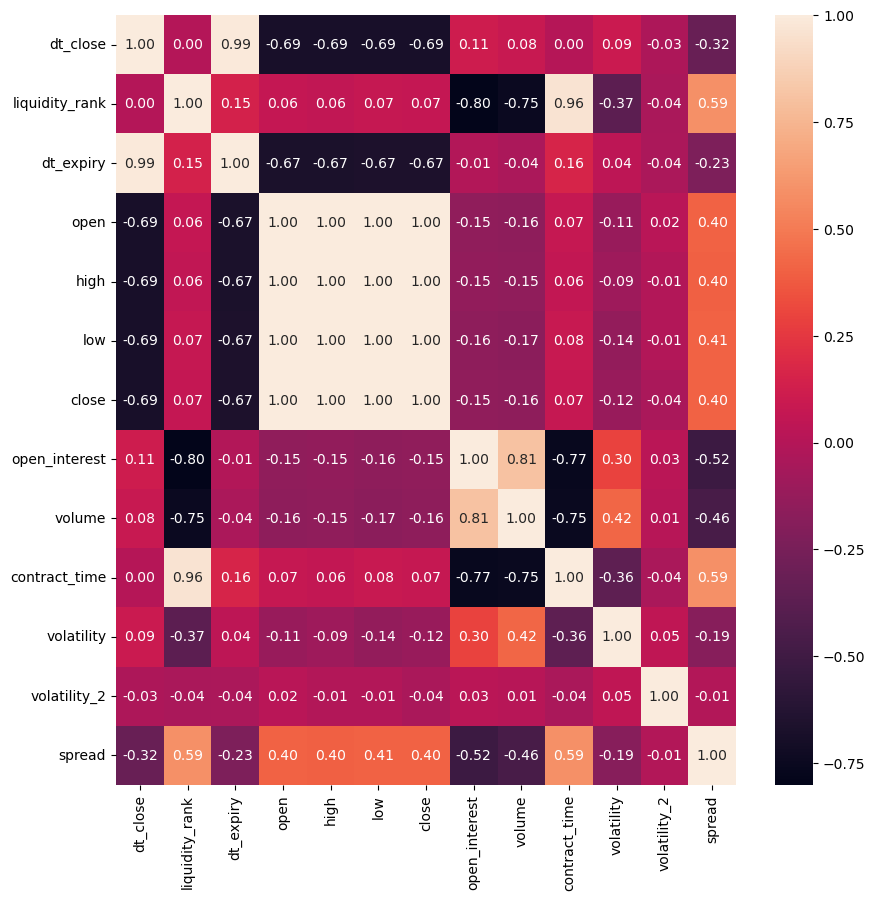

In [173]:
input_train["spread"]=output_train["spread"]
corr_mat=input_train[input_train["product_id"]==401920].drop(["product_id","tick_size"],axis=1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_mat,annot=True,fmt=".2f")

It looks like normal_trading_day and fixed are not very correlated with the spread so we can drop them. Also seems like some of the variables like open_interest, liquidity rank and volume are highly correlated. Similarly OHLC variables are highly correlated. Lets do some feature engineering to see if we can find better features. 

In [186]:
input_train.drop(["normal_trading_day","fixed"],axis=1,inplace=True)

input_train["contract_time"]=input_train["dt_expiry"]-input_train["dt_close"]
input_train["volatility"]=2*(input_train["high"] - input_train["low"])/(input_train["high"] + input_train["low"])
input_train["volatility_2"]=2*(input_train["open"] - input_train["close"])/(input_train["open"] + input_train["close"])
input_train.head()


,dt_close,product_id,liquidity_rank,dt_expiry,open,high,low,close,open_interest,volume,tick_size,spread,contract_time,volatility,volatility_2
0,8862,401920,0,8952,2710.0,2721.0,2624.0,2635.0,2814,402,11,2.552161,90,0.036296,0.028064
1,8862,401920,1,8995,2610.0,2638.0,2547.0,2560.0,905,107,11,3.575163,133,0.035101,0.019342
2,8862,401920,2,9039,2530.0,2550.0,2468.0,2478.0,719,41,11,5.351175,177,0.032682,0.020767
3,8862,401920,3,9104,2497.0,2508.0,2437.0,2443.0,466,25,11,5.285281,242,0.028716,0.021862
4,8862,401920,4,9213,2474.0,2505.0,2443.0,2452.0,286,11,11,9.712062,351,0.025061,0.008932


<Axes: >

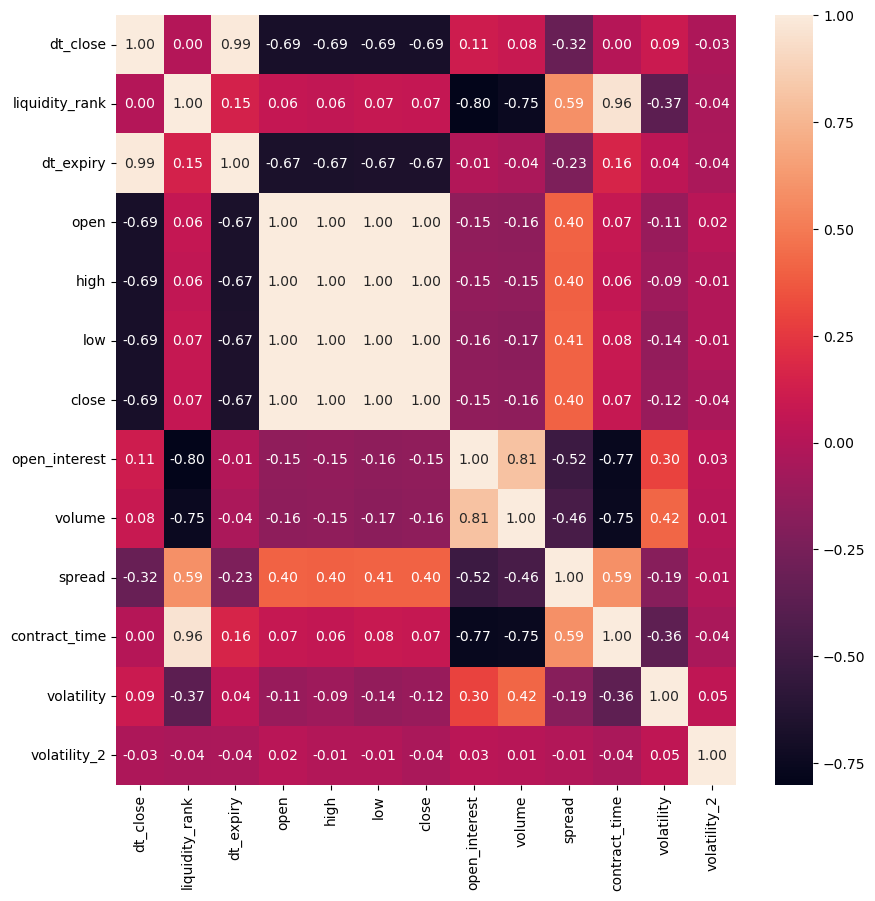

In [188]:
corr_mat=input_train[input_train["product_id"]==401920].drop(["product_id","tick_size"],axis=1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_mat,annot=True,fmt=".2f")

Looks like contract time is nicely correlated with the spread. Volatility is also decently correlated with the spread whereas volatility_2 is not so correlated with the data. So we can drop it. We will also drop dt_expiry, liquidity_rank, open interest, high,low,close since they seem to highly correlated with some of the other variables.  

In [191]:
array1=input_train["product_id"].unique()
array2=input_test["product_id"].unique()

array=[]

for num in array1:
    if num not in array2:
        array.append(num)
        
#print(array)

In [195]:

X = input_train.drop("spread",axis=1)

Y = output_train.copy()

dropped_columns=["high","low","close","dt_expiry","liquidity_rank","open_interest","volatility_2"]
X.drop(dropped_columns,axis=1,inplace=True)

In [73]:
output_train.drop("ID",axis=1,inplace=True)

data=input_train.copy()
data["spread"]=output_train.copy()

data_new=data[(data["product_id"]==42886656) | (data["product_id"]==63489024)]
data_new.head()

#Y=data_new["spread"]
#X=data_new.drop("spread",axis=1)

#Y = pd.DataFrame(Y, columns=['spread'])


,ID,dt_close,product_id,liquidity_rank,normal_trading_day,dt_expiry,open,high,low,close,open_interest,volume,tick_size,fixed,contract_time,avg_price,volatility,volatility_2,spread
33,33,8862,42886656,0,1,8897,2652.0,2720.0,2649.0,2693.0,64985,14226,16,0,35,2678.50,0.026448,-0.015341,1.902451
34,34,8862,42886656,1,1,8963,2696.0,2757.0,2696.0,2727.0,58979,6203,16,0,101,2719.00,0.022373,-0.011433,2.211221
35,35,8862,42886656,2,1,9006,2715.0,2772.0,2712.0,2739.0,23676,986,16,0,144,2734.50,0.021882,-0.008801,3.063636
36,36,8862,42886656,3,1,9050,2741.0,2774.0,2740.0,2753.0,11453,554,16,0,188,2752.00,0.012332,-0.004368,4.083333
37,37,8862,42886656,4,1,9093,2753.0,2783.0,2752.0,2765.0,8406,74,16,0,231,2763.25,0.011201,-0.004349,4.111111


<Axes: >

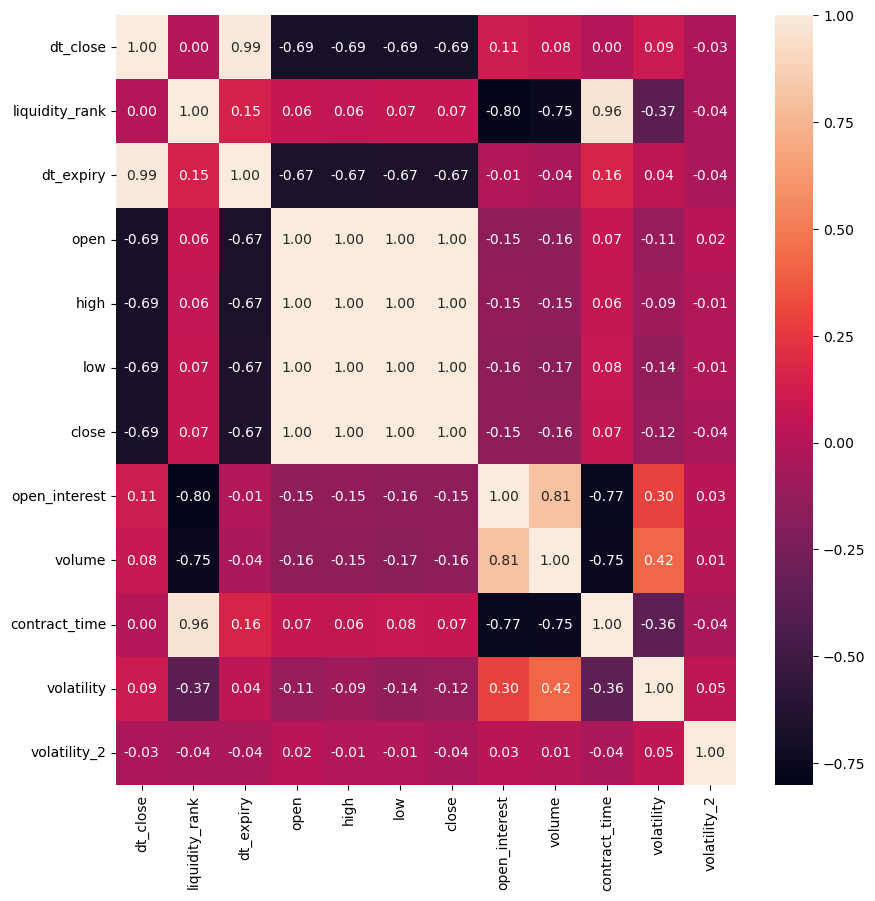

In [167]:
corr_mat=input_train[input_train["product_id"]==401920].drop(["product_id","tick_size"],axis=1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_mat,annot=True,fmt=".2f")

In [251]:
X.head()

,dt_close,product_id,open,volume,tick_size,contract_time,volatility
0,8862,401920,2710.0,402,11,90,0.036296
1,8862,401920,2610.0,107,11,133,0.035101
2,8862,401920,2530.0,41,11,177,0.032682
3,8862,401920,2497.0,25,11,242,0.028716
4,8862,401920,2474.0,11,11,351,0.025061


<Axes: >

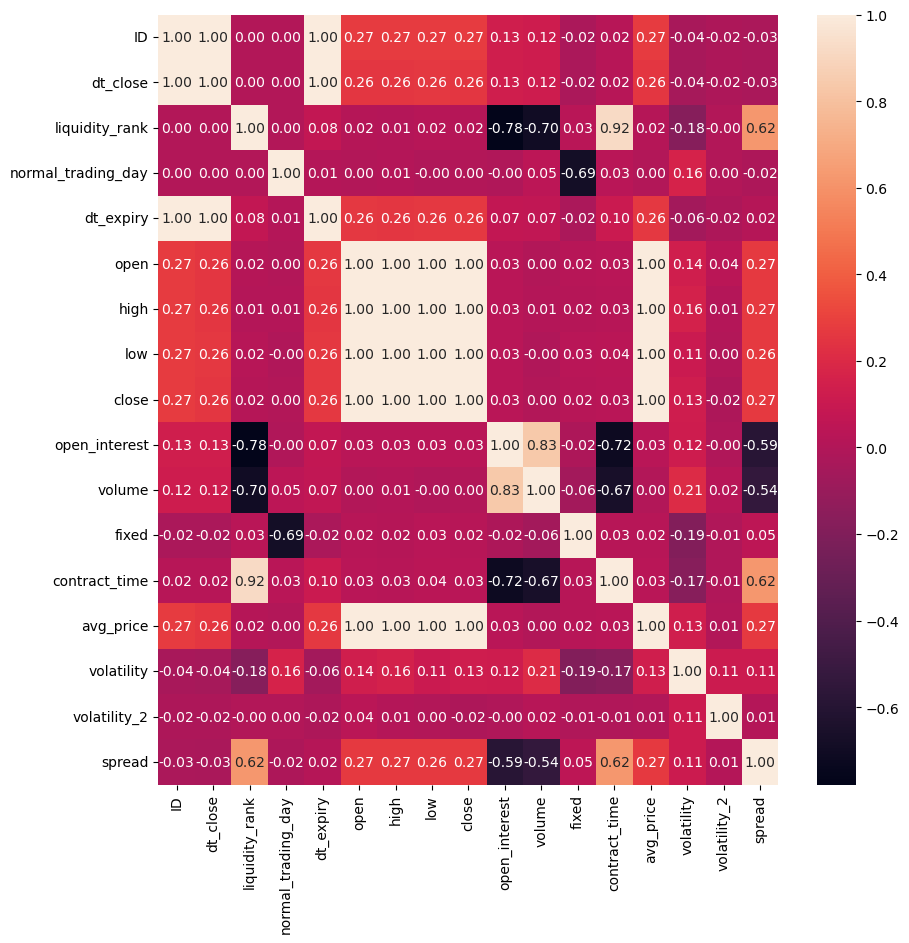

In [75]:
corr_mat=data[data["product_id"]==63489024].drop(["product_id","tick_size"],axis=1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_mat,annot=True,fmt=".2f")

We will now train CatBoostRegressor on the data since there are a lot of product_id's and cat boost is very useful when there is categorical data. We will also employ cross-validation to find the best model.  

In [239]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

model_cv = CatBoostRegressor(depth=8, learning_rate=0.03, early_stopping_rounds=40, loss_function="RMSE", verbose=False)

scores = cross_val_score(
    model_cv, 
    X, 
    Y, 
    cv=5, 
    scoring="neg_root_mean_squared_error",
    fit_params={"cat_features": ["product_id"]}
)

cv_rmse = -scores
cv_rmse.mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


1.0767117338128438

Now lets use this model to predict the bid-ask spread for the test data

In [249]:
input_test["contract_time"]=input_test["dt_expiry"]-input_test["dt_close"]
input_test["volatility"]=2*(input_test["high"] - input_test["low"])/(input_test["high"] + input_test["low"])

dropped_columns_2=["dt_expiry","fixed","ID","high","low","close","liquidity_rank","normal_trading_day","open_interest"]
X_test=input_test.drop(dropped_columns_2,axis=1)
X_test.head()



,dt_close,product_id,open,volume,tick_size,contract_time,volatility
0,8868,102103552,9299.0,3033,11,11,0.040328
1,8868,102103552,9279.0,844,11,33,0.039529
2,8868,102103552,9196.0,358,11,56,0.038079
3,8868,102103552,9174.0,293,11,78,0.036983
4,8868,102103552,9153.0,138,11,98,0.035842


In [247]:
cat_feature_names = X_test.columns
X_test[cat_feature_names] = X_test[cat_feature_names].astype(str)
    
test_pred=model.predict(X_test)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name ID (found dt_close).

In [15]:
df=pd.DataFrame({"ID":input_test["ID"],"spread":test_pred})
df.to_csv("predictions2.csv",index=False)

The test predictions gave a rmse score of 0.63  